# Topic Modelling Twitter

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import dotenv
import os
from dotenv import load_dotenv

# import tweepy
import tweepy

# datetime
from datetime import datetime, timedelta

# plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True) #do not miss this line

# gensim
from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load env file
load_dotenv(".env")

# setting API Twitter
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [3]:
# initialize crawler parameters

# date
maximum_days = 7
today = datetime.today()
date_max = today - timedelta(days=maximum_days)

# query
query = "#Udacity OR #udacity OR Udacity OR udacity"

In [4]:
# initialize dataframe
df_tweet = pd.DataFrame({'user_id': [], 'username': [], 'created_at': [], 'text': []})

# crawling tweet documents
c = tweepy.Cursor(api.search, q=query, tweet_mode='extended').items()
while True:
    try:
        tweet = c.next()
        
        # get clean tweet without RT
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            user_id = tweet.user.id
            username = tweet.user.screen_name
            created = tweet.created_at
            text = tweet.full_text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

            # get tweet documents before maximum_days
            if tweet.created_at < date_max:
                break
            df_tweet = df_tweet.append({'user_id': user_id, 'username': username, 
                                        'created_at': created, 'text': text}, ignore_index=True)
                       
    except tweepy.TweepError as e:
        print(e.reason)
        time.sleep(15 * 60)
        continue
    except StopIteration:
        break

In [5]:
df_tweet.head(10)

,user_id,username,created_at,text
0,1.555502e+09,Draconiferous,2019-08-18 03:16:30,@AkshanshD @Google @udacity Congrats
1,9.628254e+17,EvelynMDDavis,2019-08-18 01:46:59,@udacity @Bertelsmann_com Hello... Is there an...
2,3.858981e+08,muhamuttaqien,2019-08-18 01:12:38,Answer to Are Udacity Nanodegrees worth it for...
3,4.033752e+09,M_JAMAL_A,2019-08-17 23:50:18,@1MACoders @Microsoft @udacity دائما page expi...
4,8.269117e+17,SelfDrivingFEED,2019-08-17 23:42:23,Udacity behavioral cloning https://t.co/eHEIrc...
5,1.224528e+09,websiteclones,2019-08-17 22:52:00,Do you want to boost-start your own #startup i...
6,7.341791e+17,siliconlikes,2019-08-17 21:12:06,“Pytorch Cheat Sheet for Beginners and Udacity...
7,3.269122e+08,udacity,2019-08-17 21:00:04,"Michele, a learning technologist at Udacity, w..."
8,9.603384e+07,CarlRioux,2019-08-17 20:49:02,How reputable is Udacity's Machine Learning Co...
9,3.662608e+08,0luwarotimi,2019-08-17 20:43:54,Great intoduction to secure and private AI. Th...


In [6]:
range(len(df_tweet['text']))

range(0, 488)

## Tweet Activity

References: https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets

In [7]:
df_tweet.dtypes

user_id              float64
username              object
created_at    datetime64[ns]
text                  object
dtype: object

In [8]:
# df_tweet['created_at'] = df_tweet['created_at'].dt.strftime('%y-%m-%d %H:%M:%S')
tweetsT = df_tweet['created_at'] 


trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity',
    height=450,
    width=1000,
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Make Corpus

In [9]:
corpus = list()
a = list()
for i in range(len(df_tweet['text'])):
    a = df_tweet['text'][i]
    corpus.append(a)

In [10]:
corpus[0:5]

['@AkshanshD @Google @udacity Congrats',
 '@udacity @Bertelsmann_com Hello... Is there any updates on this scholarship?\n\nThank You',
 'Answer to Are Udacity Nanodegrees worth it for finding a job? by Seth Weidman https://t.co/WThiA1CMUa',
 '@1MACoders @Microsoft @udacity دائما page expired\nولا نافع معها refresh',
 'Udacity behavioral cloning https://t.co/eHEIrcs5ZW #autonomousCar #selfDrivingCar']

In [11]:
import gensim
import logging
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\YASIRA~1\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation

# remove common words and tokenize
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

[nltk_data] Downloading package stopwords to C:\Users\Yasir Abdur
[nltk_data]     Rohman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'tweet_documents.dict'))  # store the dictionary, for future reference
#print(dictionary)

2019-08-18 10:21:40,014 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-08-18 10:21:40,055 : INFO : built Dictionary(3913 unique tokens: ['@akshanshd', '@google', '@udacity', 'congrats', '@bertelsmann_com']...) from 488 documents (total 7957 corpus positions)
2019-08-18 10:21:40,055 : INFO : saving Dictionary object under C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.dict, separately None
2019-08-18 10:21:40,064 : INFO : saved C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.dict


In [14]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweet_documents.mm'), corpus)  # store to disk, for later use

2019-08-18 10:21:40,096 : INFO : storing corpus in Matrix Market format to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm
2019-08-18 10:21:40,099 : INFO : saving sparse matrix to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm
2019-08-18 10:21:40,102 : INFO : PROGRESS: saving document #0
2019-08-18 10:21:40,143 : INFO : saved 488x3913 matrix, density=0.400% (7644/1909544)
2019-08-18 10:21:40,143 : INFO : saving MmCorpus index to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm.index


In [15]:
from gensim import corpora, models, similarities

In [16]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2019-08-18 10:21:40,187 : INFO : collecting document frequencies
2019-08-18 10:21:40,190 : INFO : PROGRESS: processing document #0
2019-08-18 10:21:40,195 : INFO : calculating IDF weights for 488 documents and 3913 features (7644 matrix non-zeros)


In [17]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [18]:
total_topics = 3

In [19]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2019-08-18 10:21:40,264 : INFO : using symmetric alpha at 0.3333333333333333
2019-08-18 10:21:40,266 : INFO : using symmetric eta at 0.3333333333333333
2019-08-18 10:21:40,269 : INFO : using serial LDA version on this node
2019-08-18 10:21:40,292 : INFO : running online (single-pass) LDA training, 3 topics, 1 passes over the supplied corpus of 488 documents, updating model once every 488 documents, evaluating perplexity every 488 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-18 10:21:40,294 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-08-18 10:21:41,197 : INFO : -9.481 per-word bound, 714.5 perplexity estimate based on a held-out corpus of 488 documents with 7957 words
2019-08-18 10:21:41,201 : INFO : PROGRESS: pass 0, at document #488/488
2019-08-18 10:21:42,129 : INFO : topic #0 (0.333): 0.016*"@udacity" + 0.009*"udacity" + 0.005*"learning" + 0.005*"✅" + 0.004*"cou

In [20]:
#Show first n important word in the topics:
lda.show_topics(total_topics, 5)

[(0,
  '0.016*"@udacity" + 0.009*"udacity" + 0.005*"learning" + 0.005*"✅" + 0.004*"course"'),
 (1,
  '0.012*"udacity" + 0.010*"@udacity" + 0.006*"nanodegree" + 0.006*"new" + 0.006*"•"'),
 (2,
  '0.022*"@udacity" + 0.012*"udacity" + 0.006*"day" + 0.006*"course" + 0.005*"@google"')]

In [21]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [22]:
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(50, 3)
(3, 50)


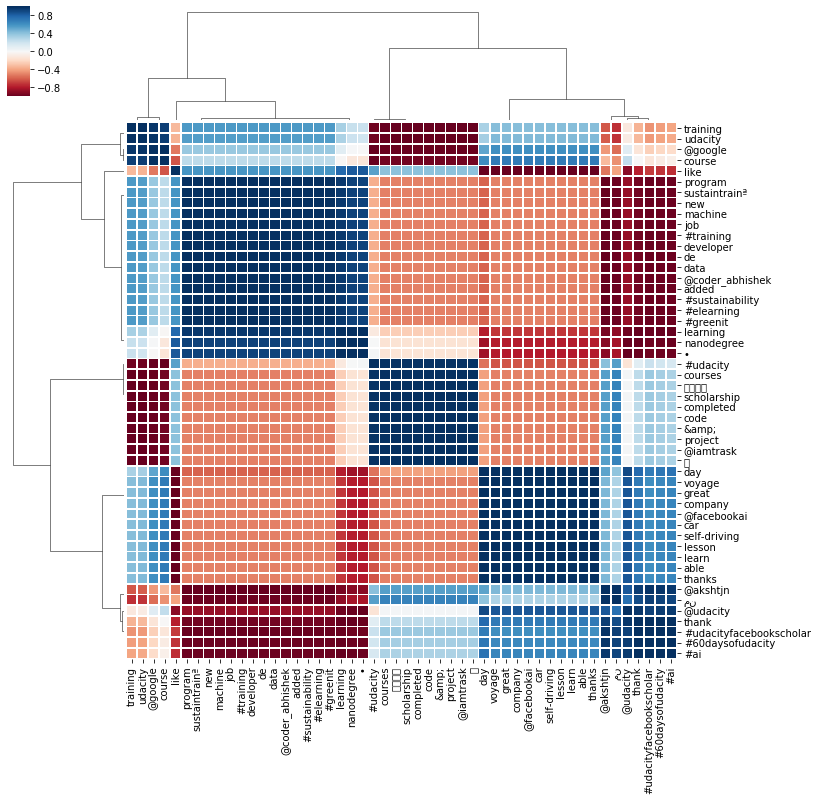

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [24]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
2      -632.045471 -384.325073       1        1  63.027805
1     -1209.665405  212.164124       2        1  18.617653
0     -1437.453247 -586.322510       3        1  18.354538, topic_info=     Category      Freq                     Term     Total  loglift  logprob
15    Default  5.000000                  udacity  5.000000  30.0000  30.0000
187   Default  0.000000                        •  0.000000  29.0000  29.0000
2     Default  9.000000                 @udacity  9.000000  28.0000  28.0000
247   Default  1.000000                      new  1.000000  27.0000  27.0000
176   Default  1.000000               nanodegree  1.000000  26.0000  26.0000
308   Default  0.000000                        ✅  0.000000  25.0000  25.0000
54    Default  2.000000                 learning  2.000000  24.0000  24.0000
116   Default  0.000000                       de  0.000000  23.0000  23.0000
262   Default  0.000000                completed  0.000000  22.0000  22.0000
241   Default  0.000000                #training  0.000000  21.0000  21.0000
243   Default  2.000000                   course  2.000000  20.0000  20.0000
239   Default  0.000000                 #greenit  0.000000  19.0000  19.0000
242   Default  0.000000                    added  0.000000  18.0000  18.0000
273   Default  0.000000                     like  0.000000  17.0000  17.0000
2692  Default  0.000000          @coder_abhishek  0.000000  16.0000  16.0000
240   Default  0.000000          #sustainability  0.000000  15.0000  15.0000
964   Default  0.000000                  project  0.000000  14.0000  14.0000
350   Default  0.000000                       🎉🥳  0.000000  13.0000  13.0000
178   Default  0.000000                  program  0.000000  12.0000  12.0000
90    Default  0.000000                  machine  0.000000  11.0000  11.0000
332   Default  0.000000                      job  0.000000  10.0000  10.0000
248   Default  0.000000            sustaintrainª  0.000000   9.0000   9.0000
185   Default  0.000000                     tech  0.000000   8.0000   8.0000
1     Default  2.000000                  @google  2.000000   7.0000   7.0000
618   Default  0.000000                    apply  0.000000   6.0000   6.0000
43    Default  1.000000                 #udacity  1.000000   5.0000   5.0000
297   Default  0.000000                @iamtrask  0.000000   4.0000   4.0000
166   Default  0.000000                     data  0.000000   3.0000   3.0000
447   Default  0.000000                developer  0.000000   2.0000   2.0000
238   Default  0.000000               #elearning  0.000000   1.0000   1.0000
...       ...       ...                      ...       ...      ...      ...
752    Topic3  0.114590                     easy  0.216000   1.0614  -6.6614
421    Topic3  0.138950              development  0.290575   0.9575  -6.4687
297    Topic3  0.221787                @iamtrask  0.541272   0.8031  -6.0011
1572   Topic3  0.143158                coursera,  0.310495   0.9211  -6.4388
964    Topic3  0.255384                  project  0.717552   0.6622  -5.8600
2611   Topic3  0.103079                wahyudi's  0.206659   0.9997  -6.7673
2      Topic3  1.469749                 @udacity  9.216761  -0.1406  -4.1099
15     Topic3  0.831378                  udacity  5.569928  -0.2068  -4.6797
661    Topic3  0.304301                       من  1.256439   0.2773  -5.6848
165    Topic3  0.208305                  courses  0.681033   0.5107  -6.0638
54     Topic3  0.440165                 learning  2.375379   0.0095  -5.3156
295    Topic3  0.337418                 @akshtjn  1.623176   0.1245  -5.5815
176    Topic3  0.326110               nanodegree  1.537704   0.1445  -5.6155
273    Topic3  0.192610                     like  0.625178   0.5179  -6.1421
43     Topic3  0.275850                 #udacity  1.322684   0.1277  -5.7829
185    Topic3  0.190077                    